In [ ]:
# all_slow

In [ ]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from fastai.torch_basics import *
from fastai.basics import *
from fastai.data.all import *
from fastai.callback.all import *
from fastai.vision.all import *

from fastai2_audio.core.all import *
from fastai2_audio.augment.all import *

import torchaudio

# Tutorial: Training a Voice Recognition Model

In [ ]:
p10speakers = untar_data(URLs.SPEAKERS10, extract_func=tar_extract_at_filename)

In [ ]:
x = AudioGetter("", recurse=True, folders=None)
files_10  = x(p10speakers)
#original_aud = AudioItem.create(files[0])

## Datablock and Basic End to End Training on 10 Speakers

In [ ]:
#crop 2s from the signal and turn it to a MelSpectrogram with no augmentation
cfg_voice = AudioConfig.Voice()
a2s = AudioToSpec.from_cfg(cfg_voice)

In [ ]:
auds = DataBlock(blocks=(AudioBlock.from_folder(p10speakers, crop_signal_to=2000), CategoryBlock),  
                 get_items=get_audio_files, 
                 splitter=RandomSplitter(),
                 item_tfms = a2s,
                 get_y=lambda x: str(x).split('/')[-1][:5])

In [ ]:
cats = [y for _,y in auds.datasets(p10speakers)]

In [ ]:
#verify categories are being correctly assigned
test_eq(min(cats).item(), 0)
test_eq(max(cats).item(), 9)

In [ ]:
dbunch = auds.dataloaders(p10speakers, bs=64)

<div class = "alert alert-block alert-warning"><strong>Broken:</strong><br>Show batch is broken as it appears to just be grabbing the data from the sg, and not the sg object itself, but calls the sg's show method which relies on nchannels, which is an object of AudioSpectrogram (part of sg settings but we overrode getattr to make it work like an attribute). This means that, for the moment, the items cant show themselves for the batch, but training still works </div>


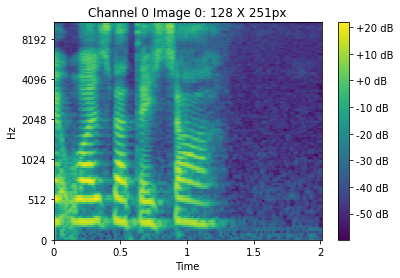

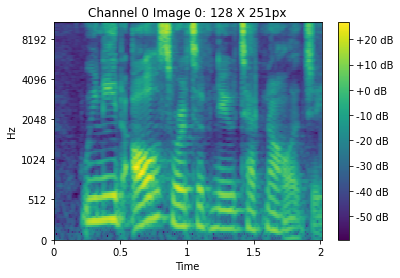

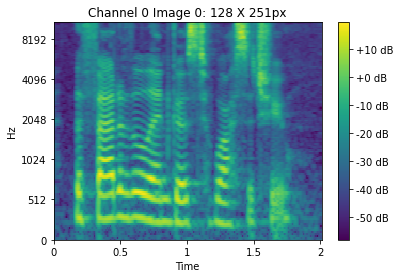

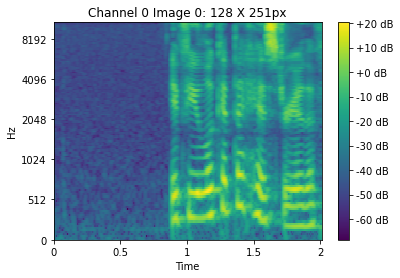

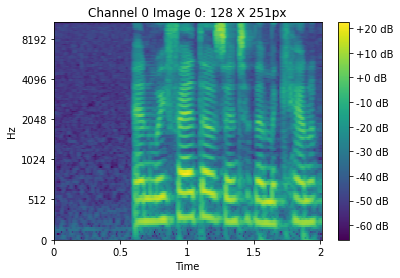

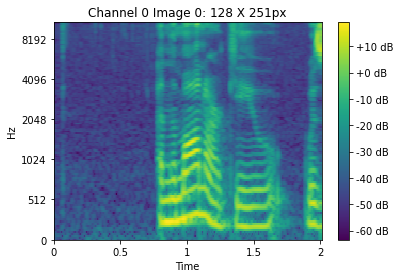

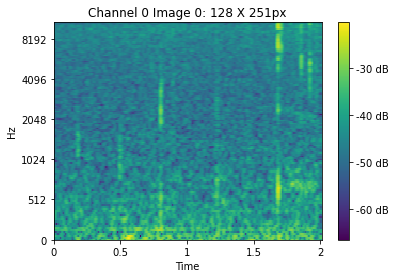

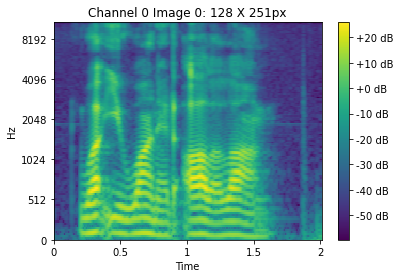

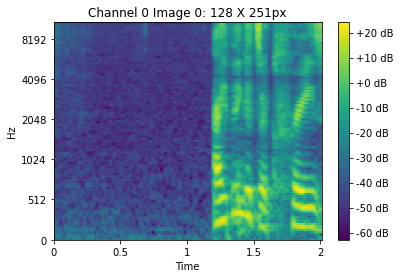

f0005
f0004
f0002
f0003
f0003
f0001
f0003
m0004
f0004


In [ ]:
dbunch.show_batch(max_n=9)

In [ ]:
dbunch.one_batch()[0].shape

torch.Size([64, 1, 128, 251])

In [ ]:
# credit to Kevin Bird and Hiromi Suenaga for these two lines to adjust a CNN model to take 1 channel input
def alter_learner(learn, channels=1):
    learn.model[0][0].in_channels=channels
    learn.model[0][0].weight = torch.nn.parameter.Parameter(learn.model[0][0].weight[:,1,:,:].unsqueeze(1))

In [ ]:
learn = Learner(dbunch, 
                xresnet18(),
                torch.nn.CrossEntropyLoss(), 
                metrics=[accuracy])
nchannels = dbunch.one_batch()[0].shape[1]
alter_learner(learn, nchannels)

SuggestedLRs(lr_min=0.017378008365631102, lr_steep=0.0030199517495930195)

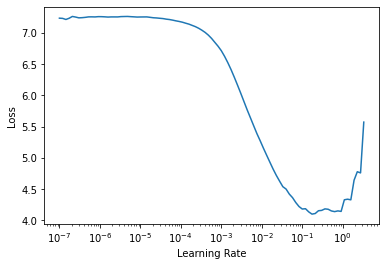

In [ ]:
learn.lr_find()

In [ ]:
#epochs are a bit longer due to the chosen melspectrogram settings
learn.fit_one_cycle(10, lr_max=slice(1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,2.092854,1.747491,0.467448,00:06
1,0.911243,14.757957,0.109375,00:06
2,0.483886,0.732704,0.821615,00:06
3,0.249270,1.417472,0.704427,00:06
4,0.132698,1.851810,0.674479,00:06
5,0.088859,1.042955,0.769531,00:06
6,0.051099,0.018470,0.993490,00:06
7,0.028633,0.019881,0.990885,00:06
8,0.016598,0.012591,0.993490,00:06
9,0.010245,0.011128,0.996094,00:06


# Training on Speech Commands

## Baseline

In [ ]:
r = torchaudio.datasets.SPEECHCOMMANDS(".", download=True)
r

In [ ]:
commands_path = Path("SpeechCommands")
audio_files = get_audio_files(commands_path)
len(audio_files)

105835

In [ ]:
for i in range(10):
    print(random.choice(audio_files))

SpeechCommands/speech_commands_v0.02/no/cd7f8c1b_nohash_0.wav
SpeechCommands/speech_commands_v0.02/on/96d8bb6f_nohash_1.wav
SpeechCommands/speech_commands_v0.02/off/5fadb538_nohash_3.wav
SpeechCommands/speech_commands_v0.02/four/dca2797e_nohash_0.wav
SpeechCommands/speech_commands_v0.02/house/042186b8_nohash_0.wav
SpeechCommands/speech_commands_v0.02/yes/ff2b842e_nohash_0.wav
SpeechCommands/speech_commands_v0.02/bed/2a1f4853_nohash_0.wav
SpeechCommands/speech_commands_v0.02/five/1b63157b_nohash_0.wav
SpeechCommands/speech_commands_v0.02/nine/879a2b38_nohash_2.wav
SpeechCommands/speech_commands_v0.02/tree/a50a98d2_nohash_0.wav


In [ ]:
for i in range(10):
    f = random.choice(audio_files)
    print("File:",f )
    print("Label:", parent_label(f))

File: SpeechCommands/speech_commands_v0.02/down/7211390b_nohash_3.wav
Label: down
File: SpeechCommands/speech_commands_v0.02/sheila/f3957e23_nohash_1.wav
Label: sheila
File: SpeechCommands/speech_commands_v0.02/marvin/c9b5ff26_nohash_0.wav
Label: marvin
File: SpeechCommands/speech_commands_v0.02/forward/62ccd358_nohash_0.wav
Label: forward
File: SpeechCommands/speech_commands_v0.02/three/b87bdb22_nohash_3.wav
Label: three
File: SpeechCommands/speech_commands_v0.02/five/94d370bf_nohash_0.wav
Label: five
File: SpeechCommands/speech_commands_v0.02/left/9151f184_nohash_3.wav
Label: left
File: SpeechCommands/speech_commands_v0.02/bed/6f5b4d3d_nohash_0.wav
Label: bed
File: SpeechCommands/speech_commands_v0.02/down/88d009d2_nohash_1.wav
Label: down
File: SpeechCommands/speech_commands_v0.02/one/31db232b_nohash_2.wav
Label: one


In [ ]:
DBMelSpec = SpectrogramTransformer(mel=True, to_db=True)
a2s = DBMelSpec()
crop_4000ms = CropSignal(4000)
tfms = [crop_4000ms, a2s]

In [ ]:
auds = DataBlock(blocks=(AudioBlock, CategoryBlock),  
                 get_items=get_audio_files, 
                 splitter=RandomSplitter(),
                 item_tfms=tfms,
                 get_y=parent_label)

In [ ]:
audio_dbunch = auds.dataloaders(commands_path, item_tfms=tfms, bs=64)

In [ ]:
learn = Learner(audio_dbunch, 
                xresnet18(),
                torch.nn.CrossEntropyLoss(), 
                metrics=[accuracy])
nchannels = audio_dbunch.one_batch()[0].shape[1]
alter_learner(learn, nchannels)

SuggestedLRs(lr_min=0.09120108485221863, lr_steep=0.00363078061491251)

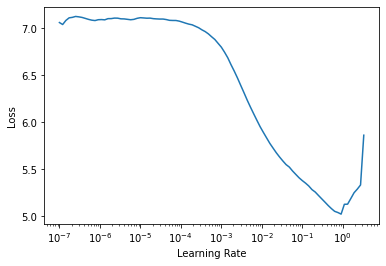

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, lr_max=slice(1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.630106,1.516957,0.621061,01:42
1,0.401712,0.383415,0.883262,01:41
2,0.271179,0.245961,0.924411,01:42
3,0.158807,0.188119,0.943355,01:56
4,0.121251,0.171937,0.947843,01:55


SuggestedLRs(lr_min=7.585775847473997e-08, lr_steep=6.309573450380412e-07)

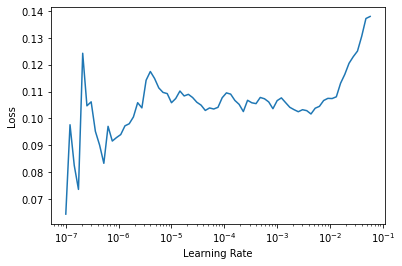

In [ ]:
learn.lr_find()

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(5, lr_max=slice(1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.116679,0.173823,0.948174,01:52
1,0.128334,0.173441,0.948457,01:58
2,0.099357,0.172425,0.949922,01:56
3,0.093348,0.168792,0.951670,01:54
4,0.069526,0.169229,0.952001,02:00


## Customize our AudioToSpec Function using a config

In [ ]:
voice_cfg = AudioConfig.Voice()
a2s = AudioToSpec.from_cfg(voice_cfg)
tfms = [crop_4000ms, a2s]
auds.item_tfms = tfms
# tfms = Pipeline([CropSignal(4000),  a2s, MaskFreq(size=12), MaskTime(size=15), SGRoll()], as_item=True)
dbunch250B = auds.dataloaders(commands_path, bs=64)

In [ ]:
learn = Learner(dbunch250B, 
                xresnet18(),
                torch.nn.CrossEntropyLoss(), 
                metrics=[accuracy])
nchannels = dbunch250B.one_batch()[0].shape[1]
alter_learner(learn, nchannels)

SuggestedLRs(lr_min=0.06309573650360108, lr_steep=0.002511886414140463)

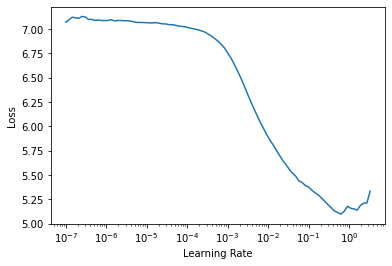

In [ ]:
learn.lr_find()

In [ ]:
# Better results even without fine tuning, but much slower. We need to move a2s to the GPU and 
# then add data augmentation!
learn.fit_one_cycle(5, lr_max=slice(2e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.191451,0.388872,0.893183,04:31
1,0.199743,0.225789,0.932395,04:37
2,0.134437,0.203080,0.941088,04:47
3,0.084259,0.135110,0.960835,04:48
4,0.050704,0.122474,0.966174,04:45


## Training an MFCC with Delta

In [ ]:
# only grab 1500ms of the clip, voice identity can be done with shorter sections and it will speed it up
# this is really slow for mfcc, even for 45k files, need to figure out what's going on here. Also the results
# shouldn't be this much worse than melspectrogram
a2mfcc = AudioToMFCC(n_mffc=20, melkwargs={"n_fft":2048, "hop_length":256, "n_mels":128})
tfms = [CropSignal(1500), a2mfcc, Delta()]
auds.item_tfms = tfms
# tfms = Pipeline([CropSignal(4000),  a2s, MaskFreq(size=12), MaskTime(size=15), SGRoll()], as_item=True)
dbunch_mfcc = auds.dataloaders(commands_path, bs=64)

In [ ]:
#n_mfcc isn't getting passed down? 
dbunch_mfcc.one_batch()[0].shape

torch.Size([64, 3, 40, 94])

In [ ]:
learn = Learner(dbunch_mfcc, 
                xresnet18(),
                torch.nn.CrossEntropyLoss(), 
                metrics=[accuracy])

SuggestedLRs(lr_min=0.15848932266235352, lr_steep=0.002511886414140463)

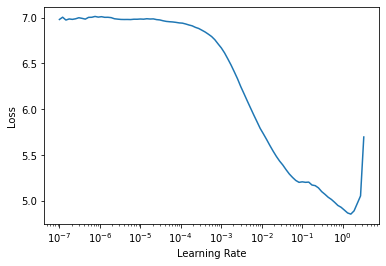

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, lr_max=slice(2e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.588547,1.146319,0.729437,02:48
1,0.367877,0.467688,0.861624,02:56
2,0.260742,0.278989,0.915482,02:59
3,0.164785,0.168895,0.946946,03:08
4,0.126781,0.152160,0.952237,02:55


<div class='alert alert-block alert-info'><strong>From Here:</strong><br>
    1. Get transforms on the GPU <br>
    2. Once it's faster test signal and spectrogram augments for speed/efficacy<br>
    3. Fine-tune and see how high we can push results on 250 speakers
</div>


In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()